# 第10章: ベクトル空間法 (II)

## 90. word2vecによる学習

In [1]:
import pandas as pd


url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states'
dataframe = pd.io.html.read_html(url)
country_names = {}
for i in dataframe[0][4:-2][0]:
    if i.startswith('ZZZ'):
        continue
    if '\xa0– ' in i:
        (country_name, long_country_name) = i.split('\xa0– ')
        country_names[country_name.split()[0]] = country_name
        country_names[long_country_name.split()[0]] = long_country_name
    else:
        country_names[i.split()[0]] = i
country_names['United'] = 'United States'


sentences = []
with open('corpus80.txt') as fd:
    for tokens in fd:
        new_tokens = []
        for (i, token) in enumerate(tokens.split()):
            if token in country_names:
                cn = country_names[token]
                if cn == tokens[i:i+len(cn)]:
                    cn = cn.replace(' ', '_')
                    new_tokens.append(cn)
            else:
                new_tokens.append(token)
        sentences.append(new_tokens)

In [2]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(sentences, size=300, min_count=1, workers=4)

In [3]:
model.wv['United_States'][:30]

array([-0.0972243 ,  0.18063697,  0.28434494, -0.291201  ,  0.53196764,
        0.64333189,  0.69922298,  0.17565008, -0.17164068,  0.45348626,
        0.29811198, -0.50383431, -0.15386386,  0.4555335 , -0.41582525,
       -0.40289488, -0.296496  , -0.40604529, -0.09800474,  0.5719372 ,
       -0.32027379, -0.74350786, -0.11100452,  0.05385117,  0.06117615,
       -0.24010094, -0.16876322, -0.06903373,  0.35681027,  0.5320546 ], dtype=float32)

In [4]:
model.similarity('United_States', 'U.S')

0.33977023932985079

In [5]:
model.similar_by_word('England', topn=10, restrict_vocab=None)

[('Scotland', 0.8622204661369324),
 ('Wales', 0.7948881983757019),
 ('Ireland', 0.7473670840263367),
 ('Britain', 0.6491029262542725),
 ('Athens', 0.6476740837097168),
 ('Liverpool', 0.6471853256225586),
 ('London', 0.6268067359924316),
 ('West', 0.6214555501937866),
 ('Manchester', 0.6119673252105713),
 ('Yorkshire', 0.6079282164573669)]

In [6]:
model.most_similar_cosmul(positive=['Spain', 'Athens'], negative=['Madrid'], topn=10)

[('Burmese', 0.9723477959632874),
 ("Jehovah's", 0.969340980052948),
 ('9/11', 0.9554938673973083),
 ('Chipko', 0.949788510799408),
 ('Colonial', 0.942867636680603),
 ('Interim', 0.942734956741333),
 ('Brotherhood', 0.9417355060577393),
 ('Gaza', 0.9396675825119019),
 ('Manchukuo', 0.9391983151435852),
 ('apartheid', 0.9379330277442932)]

## 91. アナロジーデータの準備

In [25]:
%system curl -O https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0',
 '  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0',
 '  0  589k    0  1923    0     0    454      0  0:22:10  0:00:04  0:22:06   454',
 ' 92  589k   92  543k    0     0   106k      0  0:00:05  0:00:05 --:--:--  109k',
 '100  589k  100  589k    0     0   114k      0  0:00:05  0:00:05 --:--:--  168k']

In [7]:
with open('questions-words.txt', 'r') as data_file, open('family.txt', 'w') as out_file:
    target = False
    for line in data_file:
        if target:
            if line.startswith(': '):
                break
            out_file.write(line.strip() + '\n')
        elif line.startswith(': family'):
            target = True

## 92. アナロジーデータへの適用

In [8]:
import pickle
import numpy as np
from scipy import io

with open('dict_index_t.pkl', 'rb') as data_file:
    dict_index_t = pickle.load(data_file)
keys = list(dict_index_t.keys())

matrix_x300 = io.loadmat('matrix_x300')['matrix_x300']


def cos_sim(vec_a, vec_b):
    norm_ab = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if norm_ab != 0:
        return np.dot(vec_a, vec_b) / norm_ab
    return -1


with open('family.txt', 'rt') as data_file, open('family_out_matrix300.txt', 'wt') as out_file:
    for line in data_file:
        cols = line.split(' ')
        try:
            vec = matrix_x300[dict_index_t[cols[1]]] \
                    - matrix_x300[dict_index_t[cols[0]]] \
                    + matrix_x300[dict_index_t[cols[2]]]
            dist_max = -1
            index_max = 0
            result = ''
            for i in range(len(dict_index_t)):
                dist = cos_sim(vec, matrix_x300[i])
                if dist > dist_max:
                    index_max = i
                    dist_max = dist
            result = keys[index_max]
        except KeyError:
            result = ''
            dist_max = -1
        out_file.write('%s %s %s\n' % (line.strip(), result, dist_max))

In [9]:
with open('family.txt', 'rt') as data_file, open('family_out_w2v.txt', 'wt') as out_file:
    for line in data_file:
        cols = line.split(' ')
        try:
            result = model.most_similar_cosmul(positive=[cols[1], cols[2]], negative=[cols[0]], topn=1)
        except KeyError:
            result = [('', -1)]
        out_file.write('%s %s %s\n' % (line.strip(), result[0][0], result[0][1]))

## 93. アナロジータスクの正解率の計算

In [10]:
from sklearn.metrics import accuracy_score

def calc_acc(filename):
    ground_truth = []
    predicted = []
    with open(filename) as fd:
        for line in fd:
            line = line.strip()
            cols = line.split(' ')
            ground_truth.append(cols[3])
            predicted.append(cols[4])
    print(accuracy_score(ground_truth, predicted))

calc_acc('family_out_matrix300.txt')
calc_acc('family_out_w2v.txt')

0.0276679841897
0.391304347826


## 94. WordSimilarity-353での類似度計算

In [52]:
%system curl -O http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/wordsim353.zip

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '  6 23257    6  1448    0     0   2186      0  0:00:10 --:--:--  0:00:10  2184',
 '100 23257  100 23257    0     0  23546      0 --:--:-- --:--:-- --:--:-- 23539']

In [54]:
%system unzip wordsim353.zip

['Archive:  wordsim353.zip',
 '  inflating: combined.csv            ',
 '  inflating: set1.csv                ',
 '  inflating: set2.csv                ',
 '  inflating: combined.tab            ',
 '  inflating: set1.tab                ',
 '  inflating: set2.tab                ',
 '  inflating: instructions.txt        ']

In [11]:
def cos_sim(vec_a, vec_b):
    norm_ab = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if norm_ab != 0:
        return np.dot(vec_a, vec_b) / norm_ab
    return -1

with open('combined.csv') as fd, open('combined_out_matrix300.txt', 'w') as ofd:
    next(fd)
    for line in fd:
        line = line.strip()
        cols = line.split(',')
        try:
            r = cos_sim(matrix_x300[dict_index_t[cols[0]]], matrix_x300[dict_index_t[cols[1]]])
        except KeyError:
            r = -1
        ofd.write(str(r) + '\n')

with open('combined.csv') as fd, open('combined_out_w2v.txt', 'w') as ofd:
    next(fd)
    for line in fd:
        line = line.strip()
        cols = line.split(',')
        try:
            r = model.similarity(cols[0], cols[1])
        except KeyError:
            r = -1
        ofd.write(str(r) + '\n')

## 95. WordSimilarity-353での評価

In [12]:
import numpy as np
import sklearn.preprocessing

with open('combined.csv') as fd:
    next(fd)
    human_scores = [float(l.split(',')[2]) for l in fd]
human_scores = sklearn.preprocessing.MaxAbsScaler().fit_transform(human_scores)

pred_matrix300 = [float(l.strip())for l in open('combined_out_matrix300.txt')]
print(np.correlate(human_scores, pred_matrix300))

pred_w2v = [float(l.strip())for l in open('combined_out_w2v.txt')]
print(np.correlate(human_scores, pred_w2v))

[ 17.75585558]
[ 104.25292818]


/work/venv/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:785: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/work/venv/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:818: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


## 96. 国名に関するベクトルの抽出

In [13]:
import pandas as pd


url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states'
dataframe = pd.io.html.read_html(url)
country_names = {}
for i in dataframe[0][4:-2][0]:
    if i.startswith('ZZZ'):
        continue
    if '\xa0– ' in i:
        (country_name, long_country_name) = i.split('\xa0– ')
        country_names[country_name.split()[0]] = country_name
        country_names[long_country_name.split()[0]] = long_country_name
    else:
        country_names[i.split()[0]] = i
country_names['United'] = 'United States'

In [14]:
countries = []
exist_country_names = []
for (k, v) in country_names.items():
    if v in model.wv:
        countries.append(model.wv[v])
        exist_country_names.append(k)

## 97. k-meansクラスタリング

In [15]:
import sklearn.cluster

km = sklearn.cluster.KMeans(5)
clusters = km.fit_transform(countries)

## 98. Ward法によるクラスタリング

/work/venv/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


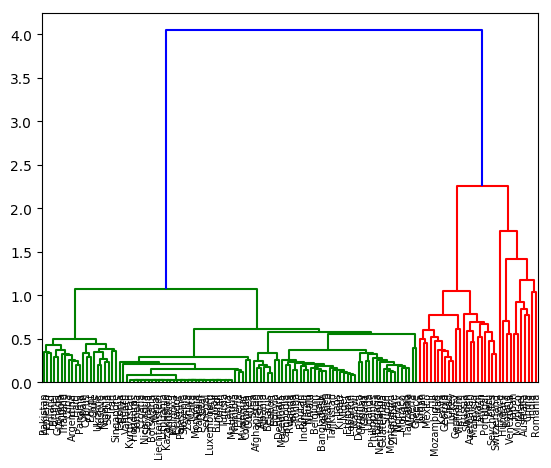

In [17]:
%matplotlib inline
from scipy.cluster.hierarchy import ward, dendrogram
from matplotlib import pyplot as plt

ward = ward(countries)
dendrogram(ward, labels=exist_country_names, leaf_font_size=7)
plt.show()

## 99. t-SNEによる可視化

/work/venv/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


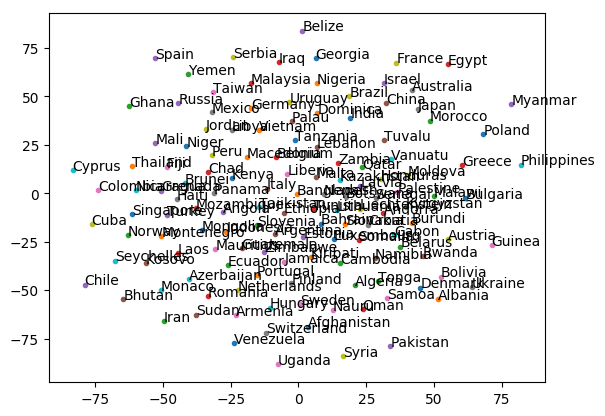

In [20]:
from sklearn.manifold import TSNE

t_sne = TSNE().fit_transform(countries)

fig, ax = plt.subplots()
cmap = plt.get_cmap('rainbow')
for index, label in enumerate(exist_country_names):
    ax.scatter(t_sne[index, 0], t_sne[index, 1], marker='.')
    ax.annotate(label, xy=(t_sne[index, 0], t_sne[index, 1]))
plt.show()